<img style="float: left;padding: 1em" src="https://raw.githubusercontent.com/gw-odw/odw-2022/main/Tutorials/logo.png">  

# **gw-odw22** | data challenge<br><br>Challenges 1 & 2

*coder*: Barone Francesco Pio  |   git@[baronefr](http://github.com/baronefr)
<br>MSc in *Physics of Data*, University of Padua, AY 2021/22


In [1]:
# requirements
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt

import pylab

from pycbc.frame import read_frame
from pycbc.waveform import get_td_waveform
import pycbc.noise
import pycbc.psd

from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr

## challenge 1

#### 1. Load the data into memory.  What are the sampling rate and duration of the data?

In [2]:
# load dataset
file_name = 'challenge1.gwf'

h1_data = read_frame(file_name, 'H1:CHALLENGE1')

In [3]:
print('sampling rate is', h1_data.get_sample_rate(), 'Hz')

sampling rate is 4096.0 Hz


In [4]:
print('duration is', len(h1_data)*h1_data.delta_t, 's') 

duration is 128.0 s


#### 2. Plot the data in the time-domain. 


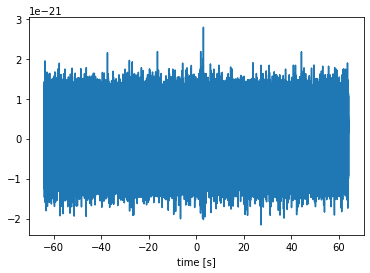

In [5]:
h1_data.plot()
plt.xlabel('time [s]')
plt.show()

#### 3. Plot a spectrogram (or q-transform) of the data, and try to identify the signal.

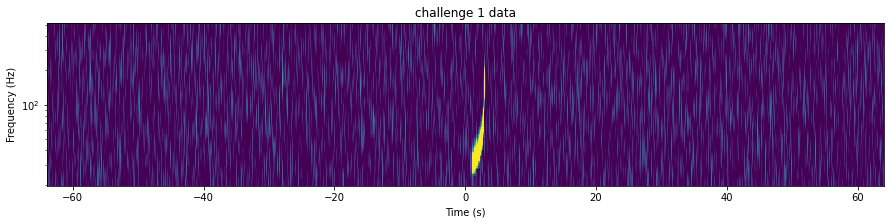

In [6]:
t, f, p = h1_data.qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20, 512))

pylab.figure(figsize=[15, 3])
pylab.title('challenge 1 data')
pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading='auto')
pylab.yscale('log')
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.show()

#### 4. What is the time of the merger?

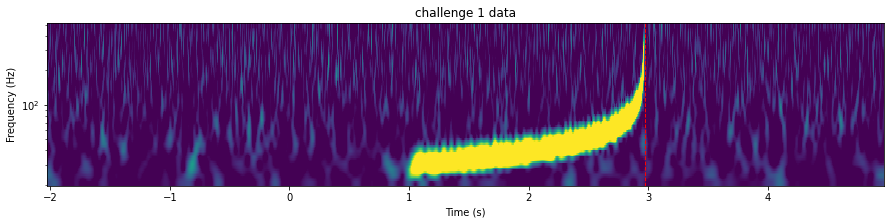

In [7]:
merger_time = 2.97
pylab.figure(figsize=[15, 3])
pylab.title('challenge 1 data')
pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading='auto')
pylab.yscale('log')
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.xlim(merger_time - 5, merger_time + 2)
pylab.axvline(x = merger_time, color = 'r', linestyle = '--', lw=1)
pylab.show()

There is a merger around $t=2.97 s$.

## challenge 2

Signal in colored, Gaussian noise.

* Use the data file "challenge2.gwf", with channel name "H1:CHALLENGE2"
* The data contain a BBH signal with m1=m2=30 solar masses, spin = 0.

#### 1. What is the approximative time of the merger? (Hint: a plot of the q-transform could help)

In [8]:
# load dataset
file_name = 'challenge2.gwf'

h1_data = read_frame(file_name, 'H1:CHALLENGE2')

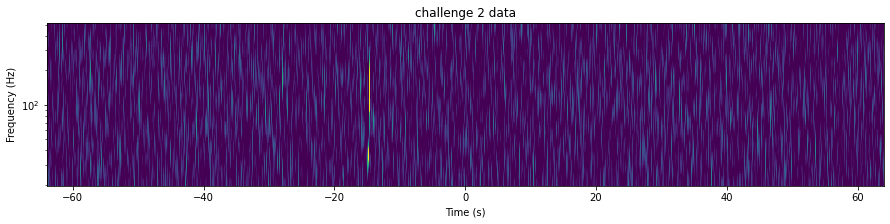

In [9]:
t, f, p = h1_data.qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20, 512))

pylab.figure(figsize=[15, 3])
pylab.title('challenge 2 data')
pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading='auto')
pylab.yscale('log')
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.show()

Let's zoom in it!

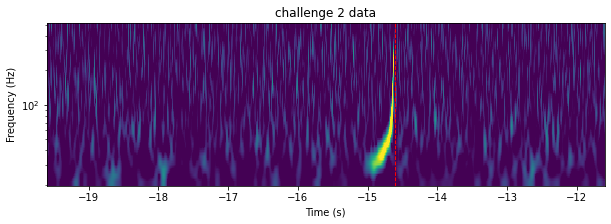

In [10]:
merger_time = -14.6
pylab.figure(figsize=[10, 3])
pylab.title('challenge 2 data')
pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading='auto')
pylab.yscale('log')
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.xlim(merger_time - 5, merger_time + 3)
pylab.axvline(x = merger_time, color = 'r', linestyle = '--', lw=1)
pylab.show()

There is a merger at approximately $t=-14.6s$.

#### 2. Generate a time-domain template waveform using approximate "SEOBNRv4_opt",  with the same parameters as above.  Plot this waveform.

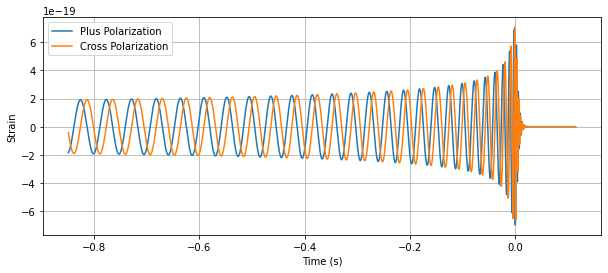

In [11]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         # spins are null by default
                         delta_t=1.0/4096,
                         f_lower=20)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

#### 3. Calculate a PSD of the data, and plot this on a log-log scale. Use axes ranging from 20 Hz up to the Nyquist frequency.

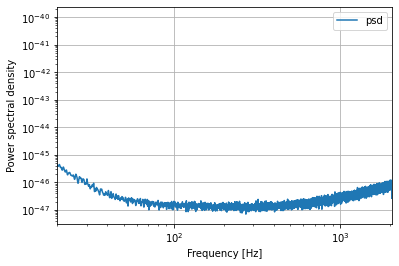

In [12]:
conditioned_ts = highpass(h1_data, 15.0)
conditioned_ts = conditioned_ts.crop(2, 2)
psd_ts = conditioned_ts.psd(4)
psd_ts = interpolate(psd_ts, conditioned_ts.delta_f)
psd_ts = inverse_spectrum_truncation(psd_ts, int(4 * conditioned_ts.sample_rate),
                                     low_frequency_cutoff=15)

# plot it:
pylab.loglog(psd_ts.sample_frequencies, psd_ts, label='psd')
pylab.xlim(xmin=20, xmax=1/(2*h1_data.delta_t))
pylab.xlabel('Frequency [Hz]')
pylab.ylabel('Power spectral density')
pylab.legend()
pylab.grid()
pylab.show()

#### 4. Use the template waveform and PSD to calculate the SNR time series. Plot the SNR time-series.

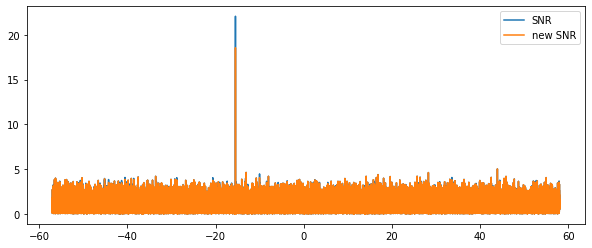

In [13]:
hp_x = hp
hp_x.resize(len(conditioned_ts))

# process snr
snr_x = matched_filter(hp_x, conditioned_ts, psd=psd_ts, low_frequency_cutoff=20).crop(5, 4)

nbins = 26
chisq_x = power_chisq(hp_x, conditioned_ts, nbins, psd_ts, low_frequency_cutoff=20.0)
chisq_x = chisq_x.crop(5, 4)
dof_x = nbins * 2 - 2
chisq_x /= dof_x

# process new snr
nsnr_x = newsnr(abs(snr_x), chisq_x)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(snr_x.sample_times, abs(snr_x), label='SNR')
pylab.plot(snr_x.sample_times, abs(nsnr_x), label='new SNR')
pylab.legend()
pylab.show()

#### 5. What is the matched filter SNR of the signal?

In [14]:
this_snr = np.max(abs(nsnr_x))
print('matched SNR is', round(this_snr,2) )

matched SNR is 18.55


End of file.